In [3]:
import torch
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [4]:
root = './models/'

In [15]:
def plot_gradient_metrics(filename):
    
    len_train_loader = 391
    
    md = torch.load(root + filename)
    
    epochs = np.sort([int(key.split()[1]) for key in md['gradient_metrics'].keys() - ['normalizing_constants']])

    nlayers = len(md['gradient_metrics'][f'epoch {epochs[0]}']['RER_layers'])
    n_epochs = len(md['gradient_metrics'].keys() - ['normalizing_constants'])
    GC_layers_min = np.zeros((nlayers, n_epochs))
    GC_layers_mean = np.zeros((nlayers, n_epochs))
    GC_stacked_min = np.zeros(n_epochs)
    GC_stacked_mean = np.zeros(n_epochs)
    RER_layers = np.zeros((nlayers, n_epochs))
    
    GD_layers = np.zeros((nlayers, n_epochs))
    GD_stacked = np.zeros(n_epochs)

    for i, key in enumerate(md['gradient_metrics'].keys() - ['normalizing_constants']):
        #print('GC_layers dim:', np.shape(md['gradient_metrics'][key]['GC_layers']))
        GC_layers_min[:, i] = np.min(md['gradient_metrics'][key]['GC_layers'], axis=1)
        GC_layers_mean[:, i] = np.mean(md['gradient_metrics'][key]['GC_layers'], axis=1)

#         #print('GC_stacked dim:', np.shape(md['gradient_metrics'][key]['GC_stacked']))
#         GC_stacked_min[i] = np.min(md['gradient_metrics'][key]['GC_stacked'])
#         GC_stacked_mean[i] = np.mean(md['gradient_metrics'][key]['GC_stacked'])

        #print('RER_layers dim:', np.shape(md['gradient_metrics'][key]['RER_layers']))
        RER_layers[:, i] = md['gradient_metrics'][key]['RER_layers']
        
        GD_layers[:, i] = md['gradient_metrics'][key]['GD_layers']
        GD_stacked[i] = md['gradient_metrics'][key]['GD_stacked']
        
        

    for i, key in enumerate(md['gradient_metrics'].keys() - ['normalizing_constants']):
        plt.plot(RER_layers[:, i], label=key)
    plt.title('RERank per layer')
    plt.xlabel('layer')
    plt.ylabel('RERank')
    plt.legend()
    plt.show()
    
    plt.plot(epochs, np.max(RER_layers, axis=0), label='max')
    plt.plot(epochs, np.mean(RER_layers, axis=0), label='mean')
    plt.plot(epochs, np.min(RER_layers, axis=0), label='min')
    plt.title('RERank layer statistics')
    plt.xlabel('epoch')
    plt.ylabel('RERank stat')
    plt.legend()
    plt.show()
    

    for i, key in enumerate(md['gradient_metrics'].keys() - ['normalizing_constants']):
        plt.plot(GC_layers_min[:, i][:-1], label=key)
    plt.title('GC min by layer (excluding last layer)')
    plt.xlabel('layer')
    plt.ylabel('mean gradient confusion')
    plt.legend()
    plt.show()

#     plt.plot(epochs, GC_stacked_min)
#     plt.title('GC stacked minimum')
#     plt.xlabel('epoch')
#     plt.show()
    
    
    for i, key in enumerate(md['gradient_metrics'].keys() - ['normalizing_constants']):
        plt.plot(GD_layers[:, i], label=key)
    plt.title('Gradient Diversity by layer using frozen network')
    plt.xlabel('layer')
    plt.ylabel('Gradient Diversity')
    plt.legend()
    plt.show()
    
    plt.plot(epochs, np.max(GD_layers, axis=0), label='max')
    plt.plot(epochs, np.mean(GD_layers, axis=0), label='mean')
    plt.plot(epochs, np.min(GD_layers, axis=0), label='min')
    plt.title('Gradient Diversity layer statistics')
    plt.xlabel('epoch')
    plt.ylabel('GD stat')
    plt.legend()
    plt.show()
    
    plt.plot([x*len_train_loader for x in epochs], GD_stacked, label='frozen network')   
    #plt.plot(np.arange(len(md['GD']['vals'])), md['GD']['vals'], label='cumulative running average')
    plt.plot(np.linspace(0, epochs[-1]*len_train_loader, len(md['GD']['vals'])), md['GD']['vals'])
    plt.title('Gradient Diversity')
    plt.xlabel('iteration')
#     plt.legend()
    plt.show()
    
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w # taken from https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy/54628145
    
    # 95% of final performance gain occurs at ?
    tol = .99
    avd = moving_average(md['losses_train'], 20)
    objective = md['losses_train'][0] - tol*(md['losses_train'][0]-avd[-1])
    plt.plot(np.arange(10, len(avd)+10)/len_train_loader*md['graph_skip'], avd)
    plt.plot(np.arange(10, len(avd)+10)/len_train_loader*md['graph_skip'], np.ones(len(avd))*objective)
    
    plt.title('moving_average_losses_train, w=20')
    plt.show()
    print(f'{tol*100}% of final performance gains achieved after {np.argmax(avd<objective)/len(avd)*epochs[-1]} epochs')
    return np.argmax(avd<objective)/len(avd)*epochs[-1], np.mean(RER_layers)

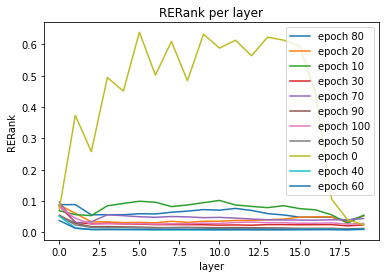

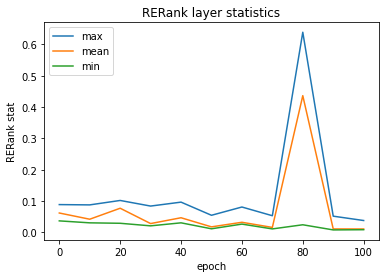

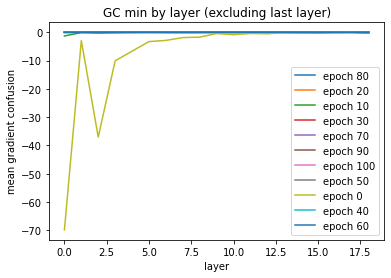

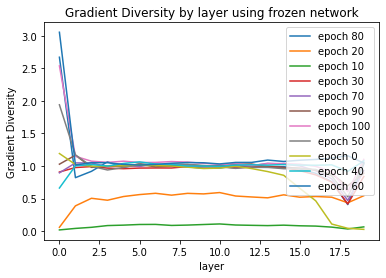

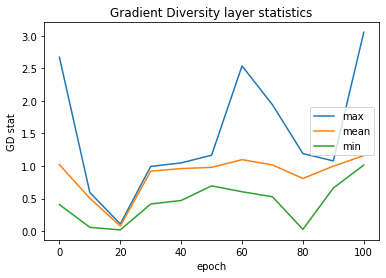

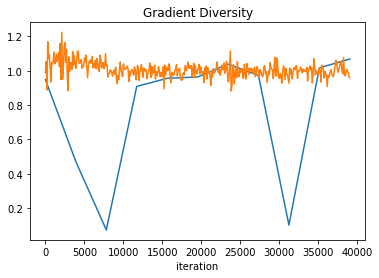

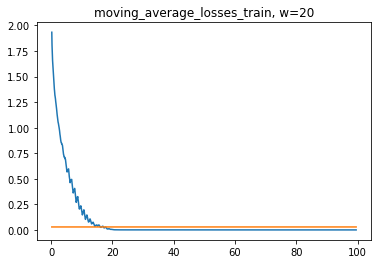

99.0% of final performance gains achieved after 16.052563772223653 epochs


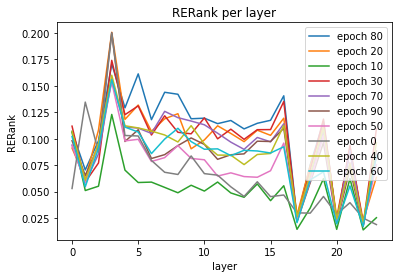

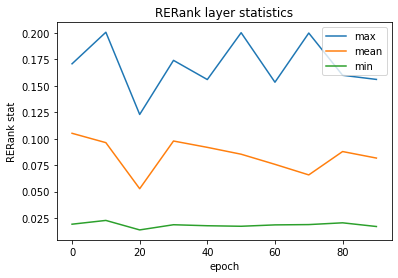

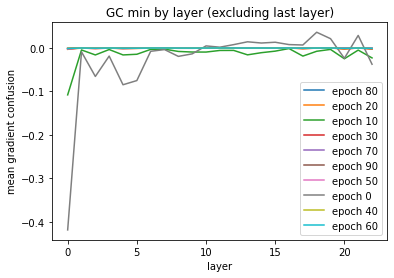

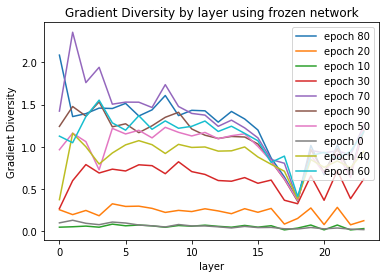

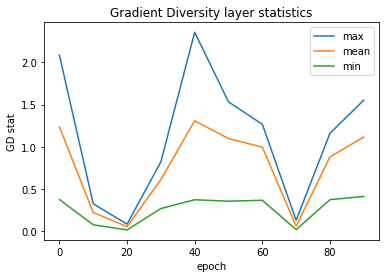

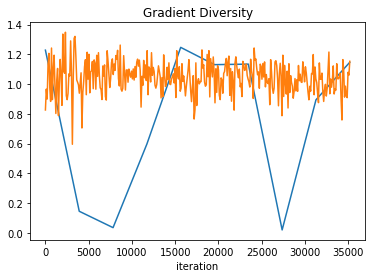

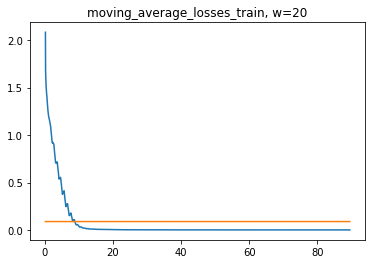

99.0% of final performance gains achieved after 8.739616155829275 epochs


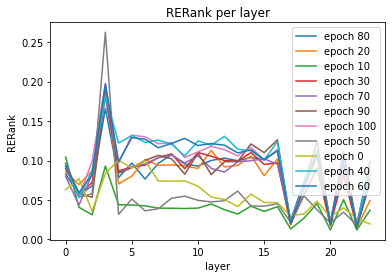

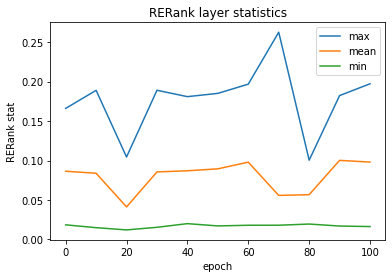

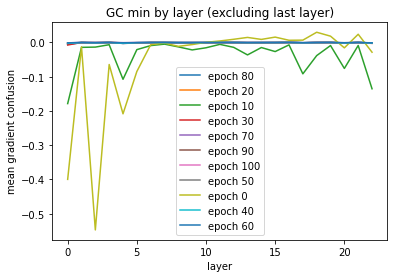

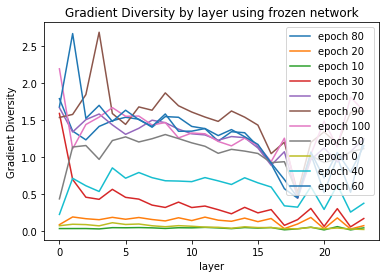

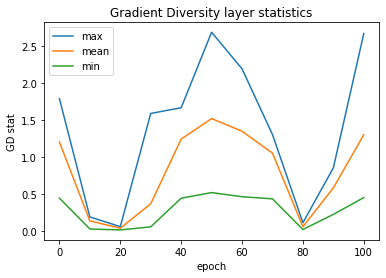

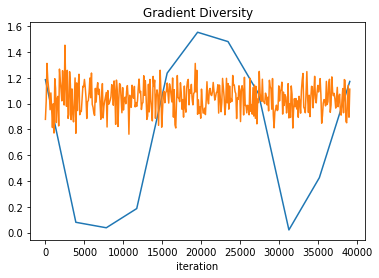

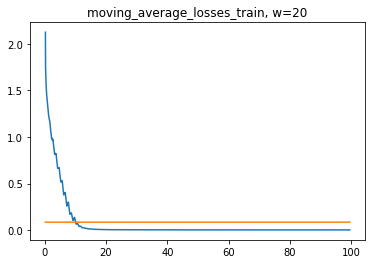

99.0% of final performance gains achieved after 9.99742334449884 epochs


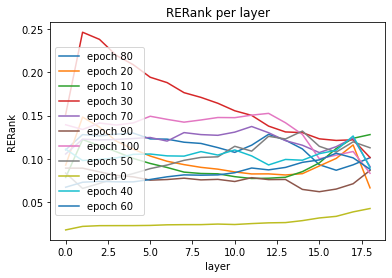

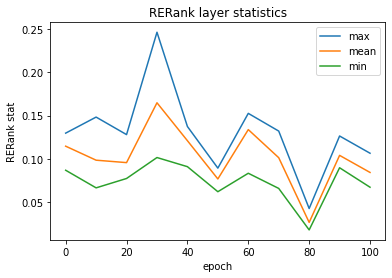

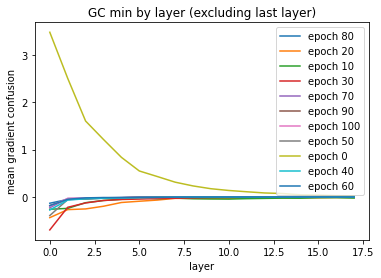

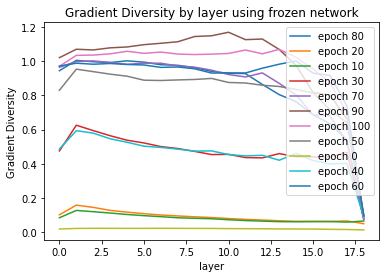

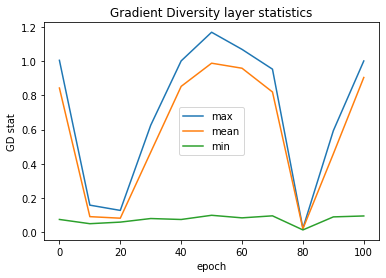

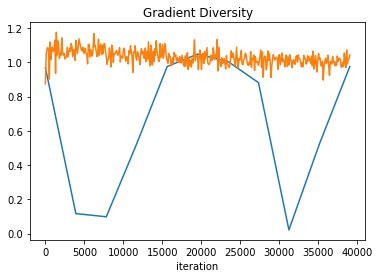

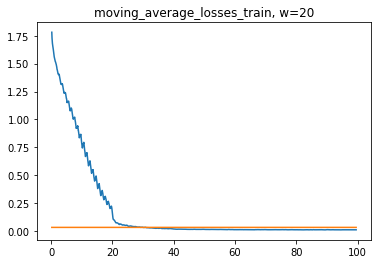

99.0% of final performance gains achieved after 29.94073692347333 epochs


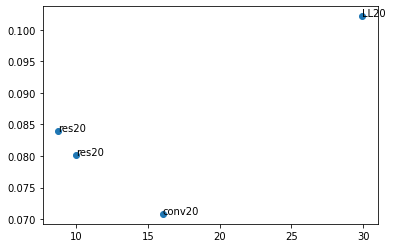

In [16]:
file20s = ['conv20_full_test1.pt','res20_full_test1.pt','res20_full_test2.pt', 'LL20_full_test_orthogonal1.pt']

names = []
tol_achieveds = np.zeros(len(file20s))
mean_RERs = np.zeros(len(file20s))

for i, filename in enumerate(file20s):
    tol_achieveds[i], mean_RERs[i] = plot_gradient_metrics(filename)
    names += [filename.split('_')[0]]
    

fig, ax = plt.subplots()
ax.scatter(tol_achieveds, mean_RERs)

for i, txt in enumerate(names):
    ax.annotate(txt, (tol_achieveds[i], mean_RERs[i]))